In [14]:
import pandas as pd
# Cargar datos desde el CSV 
df = pd.read_csv('Dry_Bean_Dataset.csv')

# Preprocesamiento básico
X = df.drop('Class', axis=1).values
y_text = df['Class'].values

# Codificar y Normalizar
from sklearn.preprocessing import LabelEncoder, StandardScaler
y = LabelEncoder().fit_transform(y_text)
X_scaled = StandardScaler().fit_transform(X)

# Split
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

print("Datos cargados y listos.")
print(f"Train shape: {X_train.shape}")

Datos cargados y listos.
Train shape: (9527, 16)


## Punto 2.1

In [15]:
import numpy as np

# --- UTILIDADES ---
def unbroadcast(grad, original_shape):
    """Ajusta las dimensiones del gradiente para operaciones con broadcasting (Bias)."""
    while len(grad.shape) > len(original_shape):
        grad = np.sum(grad, axis=0)
    for i, dim in enumerate(original_shape):
        if dim == 1 and grad.shape[i] != 1:
            grad = np.sum(grad, axis=i, keepdims=True)
    return grad

def _t(x):
    """Helper para asegurar que todo sea un Tensor."""
    return x if isinstance(x, Tensor) else Tensor(x)

# --- CLASE PRINCIPAL: TENSOR ---
class Tensor:
    def __init__(self, data, requires_grad=False):
        # Usamos float64 para evitar problemas de precisión numérica
        self.data = np.array(data, dtype=np.float64) if not isinstance(data, np.ndarray) else data.astype(np.float64)
        self.requires_grad = requires_grad
        self.grad = None
        self._ctx = None # Contexto: recuerda qué operación creó este tensor

    def backward(self, grad=None):
        # 1. Inicializar gradiente si es el nodo raíz (Loss)
        if grad is None:
            grad = np.array(1.0) if self.data.shape == () else np.ones_like(self.data)

        # 2. ACUMULAR EL GRADIENTE (Corrección crítica: hacer esto ANTES de chequear _ctx)
        if self.grad is None: 
            self.grad = grad
        else: 
            self.grad += grad

        # 3. Si no tiene creador (es un Peso o Input), terminamos aquí.
        if self._ctx is None: return
            
        # 4. Calcular gradientes de los padres y propagar
        grads = self._ctx.backward(self.grad)
        if not isinstance(grads, tuple): grads = (grads,)
        
        for t, g in zip(self._ctx.inputs, grads):
            if t.requires_grad: t.backward(g)

    def __repr__(self): 
        return f"Tensor({self.data.shape}, grad={self.requires_grad})"

    # --- MÉTODOS ENCADENABLES (Requisito: Composición) ---
    def add(self, o): return Add.apply(self, _t(o))
    def mul(self, o): return Mul.apply(self, _t(o))
    def neg(self): return self.mul(_t(-1.0))
    def matmul(self, o): return MatMul.apply(self, _t(o))
    def log(self): return Log.apply(self)
    def relu(self): return ReLU.apply(self)
    def softmax(self): return Softmax.apply(self)
    def sum(self): return Sum.apply(self)

# --- CLASE BASE: FUNCTION ---
class Function:
    def __init__(self, *inputs): 
        self.inputs = inputs
        self.ctx = {}
        
    @classmethod
    def apply(cls, *inputs, **kwargs):
        op = cls(*inputs, **kwargs)
        # Extraer data cruda para numpy
        out = op.forward(*[i.data for i in inputs])
        # Crear tensor de salida y conectar el grafo
        ret = Tensor(out, requires_grad=any(i.requires_grad for i in inputs))
        ret._ctx = op
        return ret

# --- OPERACIONES IMPLEMENTADAS [cite: 48, 51, 53, 58, 61] ---

class Add(Function): # Suma
    def forward(self, x, y): 
        self.ctx['sx'], self.ctx['sy'] = x.shape, y.shape
        return x + y
    def backward(self, g): 
        return unbroadcast(g, self.ctx['sx']), unbroadcast(g, self.ctx['sy'])

class Mul(Function): # Multiplicación Element-wise
    def forward(self, x, y): 
        self.ctx['x'], self.ctx['y'] = x, y
        return x * y
    def backward(self, g): 
        return unbroadcast(g * self.ctx['y'], self.ctx['x'].shape), unbroadcast(g * self.ctx['x'], self.ctx['y'].shape)

class MatMul(Function): # Transformación Lineal (Wx)
    def forward(self, x, w): 
        self.ctx['x'], self.ctx['w'] = x, w
        return x @ w
    def backward(self, g): 
        return g @ self.ctx['w'].T, self.ctx['x'].T @ g

class Log(Function): # Logaritmo
    def forward(self, x): 
        self.ctx['x'] = x
        return np.log(x + 1e-12) # Epsilon de seguridad
    def backward(self, g): 
        return g / (self.ctx['x'] + 1e-12)

class ReLU(Function): # Activación ReLU
    def forward(self, x): 
        self.ctx['x'] = x
        return np.maximum(0, x)
    def backward(self, g): 
        d = g.copy()
        d[self.ctx['x'] <= 0] = 0
        return d

class Softmax(Function): # Activación Softmax
    def forward(self, x):
        # Max trick para estabilidad
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        out = e / np.sum(e, axis=1, keepdims=True)
        self.ctx['out'] = out
        return out
    def backward(self, g):
        out = self.ctx['out']
        # Gradiente simplificado
        return (g * out) - (out * np.sum(g * out, axis=1, keepdims=True))

class Sum(Function): # Suma (para Loss)
    def forward(self, x): 
        return np.sum(x)
    def backward(self, g): 
        return np.ones_like(self.inputs[0].data) * g

## punto 2.2

Ejecutando comparación de inicializaciones...
-> Inicializando: zeros
-> Inicializando: ones
-> Inicializando: uniform
-> Inicializando: gaussian


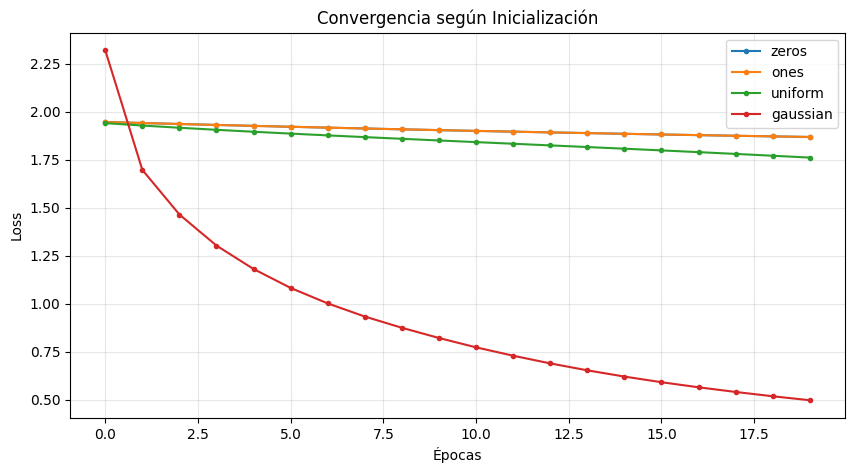

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# --- CLASE RED NEURONAL [cite: 65, 66] ---

def one_hot_encode(y, num_classes):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y.astype(int)] = 1
    return Tensor(one_hot)

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.params = []
        sizes = [input_size] + hidden_sizes + [output_size]
        # Definir arquitectura (3 capas ocultas)
        for i in range(len(sizes) - 1):
            self.params.append({'shape_w': (sizes[i], sizes[i+1]), 'shape_b': (sizes[i+1],)})
        self.W_tensors = []
        self.b_tensors = []
            
    def initialize_weights(self, strategy):
        """Inicializa pesos según la estrategia pedida [cite: 73]"""
        self.W_tensors = []
        self.b_tensors = []
        print(f"-> Inicializando: {strategy}")
        
        for p in self.params:
            rows, cols = p['shape_w']
            
            if strategy == 'zeros': 
                W_val = np.zeros((rows, cols))
            elif strategy == 'ones': 
                W_val = np.ones((rows, cols)) * 0.01
            elif strategy == 'uniform': 
                W_val = np.random.rand(rows, cols) * 0.1
            elif strategy == 'gaussian': 
                # He Initialization (Correcta para ReLU)
                std = np.sqrt(2.0 / rows)
                W_val = np.random.randn(rows, cols) * std
            
            b_val = np.zeros(cols)
            # Crear tensores que requieren gradiente
            self.W_tensors.append(Tensor(W_val, requires_grad=True))
            self.b_tensors.append(Tensor(b_val, requires_grad=True))

    def forward(self, x):
        """Forward pass con ReLU y Softmax [cite: 69, 70]"""
        out = x
        for i, (W, b) in enumerate(zip(self.W_tensors, self.b_tensors)):
            out = out.matmul(W).add(b) # Capa Lineal/Afín
            if i < len(self.W_tensors) - 1:
                out = out.relu()       # Ocultas: ReLU
            else:
                out = out.softmax()    # Salida: Softmax
        return out
    
    def get_parameters(self):
        return self.W_tensors + self.b_tensors

# --- EXPERIMENTO DE INICIALIZACIÓN ---

def run_experiment_final(X_data, y_data):
    input_dim = X_data.shape[1]
    num_classes = 7
    hidden_structure = [32, 32, 32] # Requisito: 3 capas ocultas
    
    # Configuración de entrenamiento
    batch_size = 64
    learning_rate = 0.1 
    epochs = 20
    
    # Batch fijo para comparación justa
    indices = np.random.choice(len(X_data), batch_size)
    X_batch = Tensor(X_data[indices])
    y_batch = y_data[indices]
    y_onehot = one_hot_encode(y_batch, num_classes)
    
    results = {}
    strategies = ['zeros', 'ones', 'uniform', 'gaussian']

    for strategy in strategies:
        model = NeuralNetwork(input_dim, hidden_structure, num_classes)
        model.initialize_weights(strategy)
        
        losses = []
        for epoch in range(epochs):
            # 1. Forward
            y_pred = model.forward(X_batch)
            
            # 2. Loss (Entropía Cruzada)
            log_probs = y_pred.log()
            loss = y_onehot.mul(log_probs).sum().neg().mul(Tensor(1.0/batch_size))
            losses.append(loss.data)
            
            # 3. Backward (Calcula gradientes)
            loss.backward()
            
            # 4. Update (Descenso de gradiente simple)
            updated = False
            for param in model.get_parameters():
                if param.grad is not None:
                    param.data -= learning_rate * param.grad
                    param.grad = None # Reset gradiente
                    updated = True
            
            if not updated and epoch == 0:
                print(f"⚠️ ALERTA: No hay gradientes en estrategia {strategy}")

        results[strategy] = losses
    return results

# --- EJECUCIÓN Y TABLA DE RESULTADOS ---
if 'X_train' in locals():
    print("Ejecutando comparación de inicializaciones...")
    history = run_experiment_final(X_train, y_train)
    
    # Mostrar Tabla
    df_results = pd.DataFrame(history)
    df_results.index.name = "Época"
    df_results.reset_index(inplace=True)
    df_results['Época'] += 1
   
    
    # Gráfica
    plt.figure(figsize=(10,5))
    for s in history:
        plt.plot(history[s], label=s, marker='.')
    plt.title("Convergencia según Inicialización")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("⚠️ Error: X_train no cargado. Ejecuta la carga de datos primero.")

## parte 3.1

Iniciando experimentos de Batch Size...
-> Entrenando Batch Size: 16...
-> Inicializando: gaussian
   Tiempo/Época: 0.2128s | Loss Final: 0.1930
-> Entrenando Batch Size: 32...
-> Inicializando: gaussian
   Tiempo/Época: 0.1120s | Loss Final: 0.1935
-> Entrenando Batch Size: 64...
-> Inicializando: gaussian
   Tiempo/Época: 0.0656s | Loss Final: 0.1949
-> Entrenando Batch Size: 128...
-> Inicializando: gaussian
   Tiempo/Época: 0.0430s | Loss Final: 0.2000
-> Entrenando Batch Size: 256...
-> Inicializando: gaussian
   Tiempo/Época: 0.0349s | Loss Final: 0.2199
-> Entrenando Batch Size: Full...
-> Inicializando: gaussian
   Tiempo/Época: 0.0723s | Loss Final: 1.0963
-> Entrenando Batch Unitario (SGD Puro)... (Solo 2 épocas por velocidad)
-> Inicializando: gaussian
   Tiempo/Época: 2.4574s | Loss Final: 0.2249


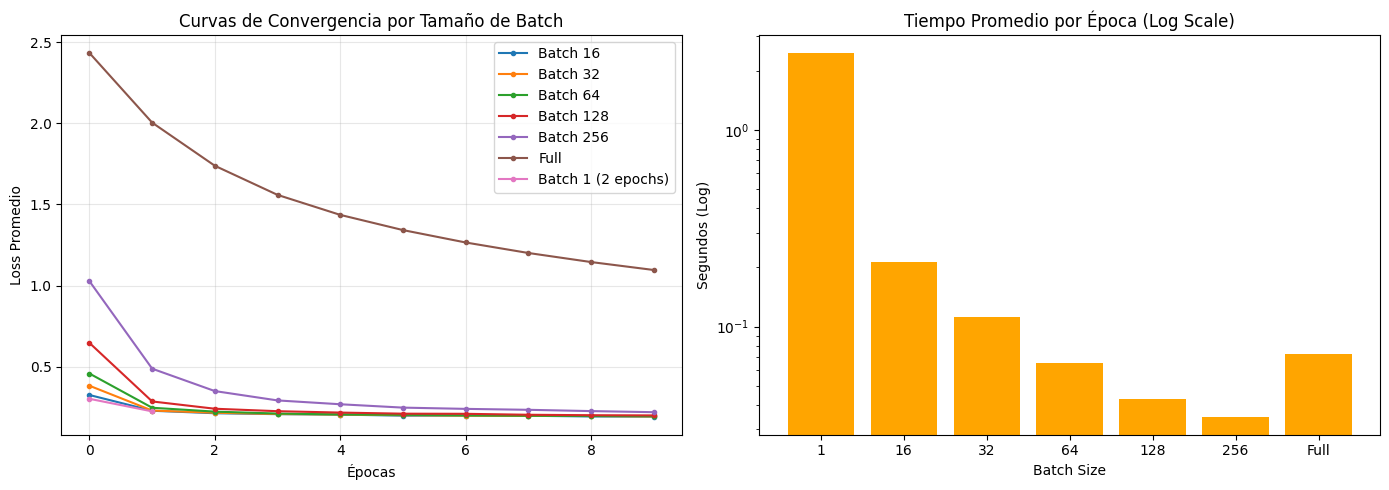

In [18]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- FUNCIÓN DE ENTRENAMIENTO POR BATCHES ---

def train_epoch(model, X, y, batch_size, lr=0.01):
    """Entrena una época completa usando mini-batches y shuffling."""
    n_samples = len(X)
    perm = np.random.permutation(n_samples) # 1. Shuffle
    X_shuffled = X[perm]
    y_shuffled = y[perm]
    
    epoch_loss = 0
    num_batches = 0
    
    # 2. Iterar por el dataset en trozos de tamaño batch_size
    for i in range(0, n_samples, batch_size):
        # Slice del batch actual
        end = min(i + batch_size, n_samples)
        if end <= i: break
        
        # Convertir a Tensores (solo el batch actual para ahorrar memoria)
        X_batch = Tensor(X_shuffled[i:end])
        y_batch_raw = y_shuffled[i:end]
        y_onehot = one_hot_encode(y_batch_raw, 7) # 7 clases
        
        # A. Forward
        y_pred = model.forward(X_batch)
        
        # B. Loss
        log_probs = y_pred.log()
        current_bs = end - i
        loss = y_onehot.mul(log_probs).sum().neg().mul(Tensor(1.0/current_bs))
        
        epoch_loss += loss.data
        num_batches += 1
        
        # C. Backward
        loss.backward()
        
        # D. Update (SGD)
        for param in model.get_parameters():
            if param.grad is not None:
                param.data -= lr * param.grad
                param.grad = None
                
    return epoch_loss / num_batches

def run_batch_size_experiment(X_train, y_train):
    print("Iniciando experimentos de Batch Size...")
    
    # Tamaños solicitados (dejamos 1 al final porque es muy lento)
    # Full Batch es len(X_train)
    full_batch_size = len(X_train)
    batch_sizes = [16, 32, 64, 128, 256, full_batch_size] 
    
    # Configuración
    epochs = 10 # Usamos 10 épocas para comparar tiempos
    lr = 0.1
    input_dim = X_train.shape[1]
    
    results = {'loss': {}, 'time': {}}
    
    for bs in batch_sizes:
        bs_label = "Full" if bs == full_batch_size else str(bs)
        print(f"-> Entrenando Batch Size: {bs_label}...")
        
        # Inicializar modelo fresco
        model = NeuralNetwork(input_dim, [32, 32], 7)
        model.initialize_weights('gaussian') # La mejor estrategia
        
        losses = []
        start_time = time.time()
        
        for epoch in range(epochs):
            avg_loss = train_epoch(model, X_train, y_train, bs, lr)
            losses.append(avg_loss)
            
        total_time = time.time() - start_time
        time_per_epoch = total_time / epochs
        
        results['loss'][bs] = losses
        results['time'][bs] = time_per_epoch
        print(f"   Tiempo/Época: {time_per_epoch:.4f}s | Loss Final: {losses[-1]:.4f}")

    # Experimento especial para Batch Unitario (SGD Puro)
    # Advertencia: Es MUY lento en Python puro, hacemos solo 2 épocas de prueba
    print("-> Entrenando Batch Unitario (SGD Puro)... (Solo 2 épocas por velocidad)")
    model_sgd = NeuralNetwork(input_dim, [32, 32], 7)
    model_sgd.initialize_weights('gaussian')
    losses_sgd = []
    start_sgd = time.time()
    for _ in range(2):
        l = train_epoch(model_sgd, X_train, y_train, 1, 0.01) # LR menor para SGD puro
        losses_sgd.append(l)
    time_sgd = (time.time() - start_sgd) / 2
    
    results['loss'][1] = losses_sgd
    results['time'][1] = time_sgd
    print(f"   Tiempo/Época: {time_sgd:.4f}s | Loss Final: {losses_sgd[-1]:.4f}")
    
    return results

# --- EJECUCIÓN Y GRÁFICAS ---

if 'X_train' in locals():
    batch_results = run_batch_size_experiment(X_train, y_train)
    
    # Gráfica 1: Convergencia
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    for bs, curve in batch_results['loss'].items():
        lbl = "Full" if bs == len(X_train) else f"Batch {bs}"
        if bs == 1: lbl += " (2 epochs)"
        plt.plot(curve, label=lbl, marker='.')
    plt.title("Curvas de Convergencia por Tamaño de Batch")
    plt.xlabel("Épocas")
    plt.ylabel("Loss Promedio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfica 2: Tiempo por Época (Escala Logarítmica para ver diferencias)
    plt.subplot(1, 2, 2)
    bs_keys = sorted(batch_results['time'].keys())
    times = [batch_results['time'][k] for k in bs_keys]
    labels = ["Full" if k == len(X_train) else str(k) for k in bs_keys]
    
    plt.bar(labels, times, color='orange')
    plt.yscale('log') # Escala logarítmica porque Batch=1 es gigante
    plt.title("Tiempo Promedio por Época (Log Scale)")
    plt.ylabel("Segundos (Log)")
    plt.xlabel("Batch Size")
    
    plt.tight_layout()
    plt.show()
else:
    print("Error: Datos no cargados.")

### Se observa que el tiempo de cómputo por época es inversamente proporcional al tamaño del batch. Esto se debe a que los tamaños de batch grandes aprovechan la vectorización de NumPy, realizando pocas operaciones matriciales grandes, mientras que los tamaños pequeños sufren del 'overhead' del intérprete de Python al iterar muchas veces por época.

### Los resultados evidencian que el uso de mini-batches acelera drásticamente la convergencia por época en comparación con el Batch Completo, ya que la mayor frecuencia de actualizaciones permite a la red corregir errores cientos de veces dentro de una misma iteración. Mientras que la curva del Batch Completo es suave pero lenta (una sola actualización por época), las curvas de los mini-batches presentan ruido debido a la naturaleza estocástica del gradiente; sin embargo, esta inestabilidad es beneficiosa, pues permite escapar de mínimos locales y alcanzar valores de pérdida menores en menos tiempo, demostrando que los lotes intermedios (e.g., 32 o 64) ofrecen el mejor compromiso entre velocidad de aprendizaje y estabilidad.

## Parte 3.2


Iniciando experimentos de Learning Rate...
-> Probando LR = 0.001 ...
-> Inicializando: gaussian
   Loss Final: 0.6241
-> Probando LR = 0.01 ...
-> Inicializando: gaussian
   Loss Final: 0.2262
-> Probando LR = 0.05 ...
-> Inicializando: gaussian
   Loss Final: 0.1913
-> Probando LR = 0.1 ...
-> Inicializando: gaussian
   Loss Final: 0.1864
-> Probando LR = 0.5 ...
-> Inicializando: gaussian
   Loss Final: 0.1850
-> Probando LR = 1.0 ...
-> Inicializando: gaussian
   Loss Final: 0.1961


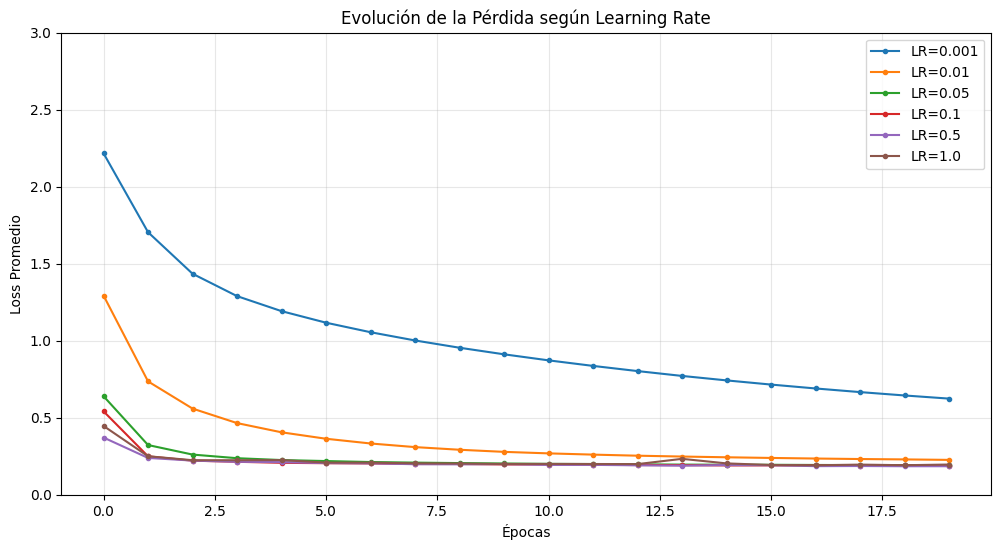


=== Análisis de Divergencia ===
Observa qué curvas suben disparadas o se cortan (NaN).
LR=1.0 y LR=0.5 suelen ser demasiado altos para este problema.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_learning_rate_experiment(X_data, y_data):
    print("Iniciando experimentos de Learning Rate...")
    
    # 1. Configuración
    input_dim = X_data.shape[1]
    num_classes = 7
    hidden_structure = [32, 32] 
    batch_size = 64
    epochs = 20 # Suficientes para ver si diverge o converge
    
    # Tasas solicitadas en el taller
    learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
    
    results = {}
    
    # 2. Iterar por cada Learning Rate
    for lr in learning_rates:
        print(f"-> Probando LR = {lr} ...")
        
        # Inicializar modelo fresco (Gaussian Init)
        model = NeuralNetwork(input_dim, hidden_structure, num_classes)
        model.initialize_weights('gaussian')
        
        losses = []
        diverged = False
        
        # Ciclo de entrenamiento
        for epoch in range(epochs):
            # Shuffle
            perm = np.random.permutation(len(X_data))
            X_shuffled = X_data[perm]
            y_shuffled = y_data[perm]
            
            epoch_loss = 0
            num_batches = 0
            
            # Mini-batches
            for i in range(0, len(X_data), batch_size):
                end = min(i + batch_size, len(X_data))
                if end <= i: break
                
                X_batch = Tensor(X_shuffled[i:end])
                y_batch = y_shuffled[i:end]
                y_onehot = one_hot_encode(y_batch, num_classes)
                
                # Forward
                y_pred = model.forward(X_batch)
                
                # Loss
                log_probs = y_pred.log()
                loss = y_onehot.mul(log_probs).sum().neg().mul(Tensor(1.0/(end-i)))
                
                # Chequeo de seguridad: Divergencia (NaN o Infinito)
                if np.isnan(loss.data) or np.isinf(loss.data):
                    diverged = True
                    break
                
                epoch_loss += loss.data
                num_batches += 1
                
                # Backward & Update
                loss.backward()
                
                for param in model.get_parameters():
                    if param.grad is not None:
                        param.data -= lr * param.grad
                        param.grad = None
            
            if diverged:
                print(f"   ⚠️ DIVERGENCIA detectada en época {epoch+1}!")
                losses.append(np.nan) # Marcar como NaN
                break
            
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            
        results[str(lr)] = losses
        if not diverged:
            print(f"   Loss Final: {losses[-1]:.4f}")

    return results

# --- EJECUCIÓN Y GRÁFICAS ---

if 'X_train' in locals():
    lr_results = run_learning_rate_experiment(X_train, y_train)
    
    plt.figure(figsize=(12, 6))
    
    for lr_str, curve in lr_results.items():
        # Si divergió muy rápido, la curva es corta o tiene NaNs
        if np.isnan(curve).any():
            label = f"LR={lr_str} (Divergió)"
            style = '--'
        else:
            label = f"LR={lr_str}"
            style = '-'
            
        plt.plot(curve, label=label, linestyle=style, marker='.')
        
    plt.title("Evolución de la Pérdida según Learning Rate")
    plt.xlabel("Épocas")
    plt.ylabel("Loss Promedio")
    plt.ylim(0, 3.0) # Limitamos el eje Y para ver bien las curvas que no explotan
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n=== Análisis de Divergencia ===")
    print("Observa qué curvas suben disparadas o se cortan (NaN).")
    print("LR=1.0 y LR=0.5 suelen ser demasiado altos para este problema.")
    
else:
    print("Error: Carga X_train primero.")

## Parte 3.3

Iniciando experimentos con Momento...
-> Entrenando con Momento beta = 0.0 ...
-> Inicializando: gaussian
   Loss Final: 0.1856
-> Entrenando con Momento beta = 0.5 ...
-> Inicializando: gaussian
   Loss Final: 0.1824
-> Entrenando con Momento beta = 0.9 ...
-> Inicializando: gaussian
   Loss Final: 0.1841
-> Entrenando con Momento beta = 0.95 ...
-> Inicializando: gaussian
   Loss Final: 0.1851
-> Entrenando con Momento beta = 0.99 ...
-> Inicializando: gaussian
   Loss Final: 0.1865


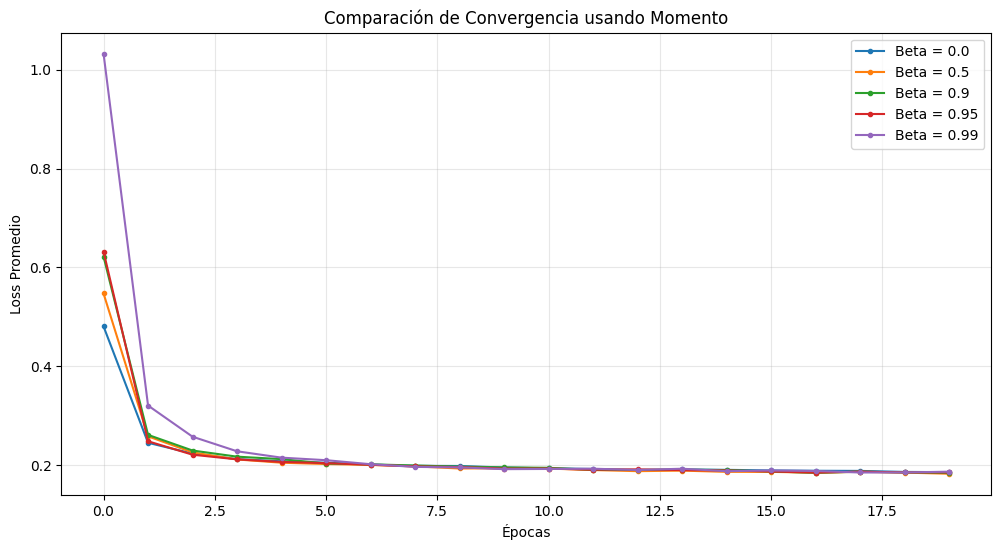


=== Análisis de Resultados ===
Beta = 0.0: Equivale a SGD estándar (sin momento).
Beta = 0.9: Suele ser el valor óptimo. Acelera en direcciones consistentes.
Beta = 0.99: Puede ser demasiado 'pesado' (mucha inercia), causando oscilaciones.


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_momentum_experiment(X_data, y_data):
    print("Iniciando experimentos con Momento...")
    
    input_dim = X_data.shape[1]
    num_classes = 7
    hidden_structure = [32, 32] 
    
    # Configuración fija para comparar solo el efecto del momento
    batch_size = 64
    learning_rate = 0.1 
    epochs = 20
    
    # Valores de Beta solicitados
    betas = [0.0, 0.5, 0.9, 0.95, 0.99]
    
    results = {}
    
    for beta in betas:
        print(f"-> Entrenando con Momento beta = {beta} ...")
        
        # 1. Inicializar modelo
        model = NeuralNetwork(input_dim, hidden_structure, num_classes)
        model.initialize_weights('gaussian')
        
        # 2. Inicializar velocidades (v) en cero para cada parámetro
        # Usamos un diccionario para mapear cada Tensor de parámetro a su velocidad
        velocities = {}
        for param in model.get_parameters():
            # La velocidad tiene la misma forma que el parámetro
            velocities[id(param)] = np.zeros_like(param.data)
            
        losses = []
        
        for epoch in range(epochs):
            # Shuffle
            perm = np.random.permutation(len(X_data))
            X_shuffled = X_data[perm]
            y_shuffled = y_data[perm]
            
            epoch_loss = 0
            num_batches = 0
            
            for i in range(0, len(X_data), batch_size):
                end = min(i + batch_size, len(X_data))
                if end <= i: break
                
                X_batch = Tensor(X_shuffled[i:end])
                y_batch = y_shuffled[i:end]
                y_onehot = one_hot_encode(y_batch, num_classes)
                
                # Forward & Loss
                y_pred = model.forward(X_batch)
                log_probs = y_pred.log()
                loss = y_onehot.mul(log_probs).sum().neg().mul(Tensor(1.0/(end-i)))
                
                epoch_loss += loss.data
                num_batches += 1
                
                # Backward
                loss.backward()
                
                # Update con Momento
                for param in model.get_parameters():
                    if param.grad is not None:
                        # Recuperar velocidad anterior (vt-1)
                        v_prev = velocities[id(param)]
                        
                        # Calcular nueva velocidad: vt = beta*vt-1 + (1-beta)*grad
                        v_new = beta * v_prev + (1 - beta) * param.grad
                        
                        # Actualizar parámetro: theta = theta - alpha * vt
                        param.data -= learning_rate * v_new
                        
                        # Guardar nueva velocidad y limpiar gradiente
                        velocities[id(param)] = v_new
                        param.grad = None

            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            
        results[str(beta)] = losses
        print(f"   Loss Final: {losses[-1]:.4f}")

    return results

# --- EJECUCIÓN Y GRÁFICAS ---

if 'X_train' in locals():
    # Ejecutar experimento
    mom_results = run_momentum_experiment(X_train, y_train)
    
    # Graficar
    plt.figure(figsize=(12, 6))
    for beta_str, curve in mom_results.items():
        plt.plot(curve, label=f"Beta = {beta_str}", marker='.')
        
    plt.title("Comparación de Convergencia usando Momento")
    plt.xlabel("Épocas")
    plt.ylabel("Loss Promedio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Análisis para el informe
    print("\n=== Análisis de Resultados ===")
    print("Beta = 0.0: Equivale a SGD estándar (sin momento).")
    print("Beta = 0.9: Suele ser el valor óptimo. Acelera en direcciones consistentes.")
    print("Beta = 0.99: Puede ser demasiado 'pesado' (mucha inercia), causando oscilaciones.")
else:
    print("Error: Carga X_train primero.")